In [1]:
import numpy as np
import bilby
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def time_domain_damped_sinusoid(
        time, amplitude, damping_time, frequency, phase, t0):
    """
    This example only creates a linearly polarised signal with only plus
    polarisation.
    """
    plus = np.zeros(len(time))
    tidx = time >= t0
    plus[tidx] = amplitude * np.exp(-(time[tidx] - t0) / damping_time) *\
        np.sin(2 * np.pi * frequency * (time[tidx] - t0) + phase)
    cross = np.zeros(len(time))
    return {'plus': plus, 'cross': cross}

In [9]:
injection_parameters = dict(amplitude=5e-22, damping_time=0.1, frequency=50,
                            phase=0, ra=0, dec=0, psi=0, t0=0., geocent_time=1126259600.0)

duration = 1.0
sampling_frequency = 1024
outdir = 'outdir'
label = 'time_domain_source_model'

# call the waveform_generator to create our waveform model.
waveform = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    time_domain_source_model=time_domain_damped_sinusoid,
    start_time=injection_parameters['geocent_time'] - 0.5)


13:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.time_domain_damped_sinusoid
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [10]:
# inject the signal into three interferometers
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 0.5)
ifos.inject_signal(waveform_generator=waveform,
                   parameters=injection_parameters)


/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/utils.py:258: RuntimeWarning: invalid value encountered in cdouble_scalars
  duration=duration)**0.5
13:45 bilby INFO    : Injected signal in H1:
13:45 bilby INFO    :   optimal SNR = 0.00
13:45 bilby INFO    :   matched filter SNR = nan+nanj
13:45 bilby INFO    :   amplitude = 5e-22
13:45 bilby INFO    :   damping_time = 0.1
13:45 bilby INFO    :   frequency = 50
13:45 bilby INFO    :   phase = 0
13:45 bilby INFO    :   ra = 0
13:45 bilby INFO    :   dec = 0
13:45 bilby INFO    :   psi = 0
13:45 bilby INFO    :   t0 = 0.0
13:45 bilby INFO    :   geocent_time = 1126259600.0
13:45 bilby INFO    : Injected signal in L1:
13:45 bilby IN

[{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.-0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.-0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

13:46 bilby INFO    : Injected signal in H1:
13:46 bilby INFO    :   optimal SNR = 0.00
13:46 bilby INFO    :   matched filter SNR = nan+nanj
13:46 bilby INFO    :   amplitude = 5e-22
13:46 bilby INFO    :   damping_time = 0.1
13:46 bilby INFO    :   frequency = 50
13:46 bilby INFO    :   phase = 0
13:46 bilby INFO    :   ra = 0
13:46 bilby INFO    :   dec = 0
13:46 bilby INFO    :   psi = 0
13:46 bilby INFO    :   t0 = 0.0
13:46 bilby INFO    :   geocent_time = 1126259600.0
13:46 bilby INFO    : Injected signal in L1:
13:46 bilby INFO    :   optimal SNR = 0.00
13:46 bilby INFO    :   matched filter SNR = nan+nanj
13:46 bilby INFO    :   amplitude = 5e-22
13:46 bilby INFO    :   damping_time = 0.1
13:46 bilby INFO    :   frequency = 50
13:46 bilby INFO    :   phase = 0
13:46 bilby INFO    :   ra = 0
13:46 bilby INFO    :   dec = 0
13:46 bilby INFO    :   psi = 0
13:46 bilby INFO    :   t0 = 0.0
13:46 bilby INFO    :   geocent_time = 1126259600.0


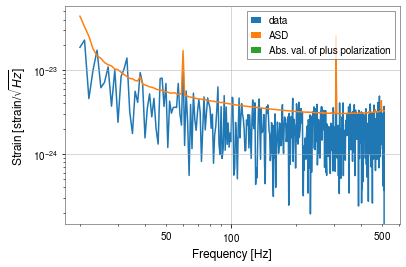

In [11]:
injection = ifos.inject_signal(waveform_generator=waveform,
                   parameters=injection_parameters)

H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["cross"][idxs]),
          label="Abs. val. of plus polarization")


ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [12]:
prior = injection_parameters.copy()
prior['amplitude'] = bilby.core.prior.LogUniform(1e-23, 1e-21, r'$h_0$')
prior['damping_time'] = bilby.core.prior.Uniform(
    0.01, 1, r'damping time', unit='$s$')
prior['frequency'] = bilby.core.prior.Uniform(0, 200, r'frequency', unit='Hz')
prior['phase'] = bilby.core.prior.Uniform(-np.pi / 2, np.pi / 2, r'$\phi$')

# define likelihood
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(ifos, waveform)


In [13]:
result = bilby.core.sampler.run_sampler(
    likelihood, prior, sampler='dynesty', npoints=1000,
    injection_parameters=injection_parameters, outdir=outdir, label=label, dlogz=3.0,npool=4)


13:46 bilby INFO    : Running for label 'time_domain_source_model', output will be saved to 'outdir'
13:46 bilby INFO    : Using lal version 7.1.2
13:46 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
13:46 bilby INFO    : Using lalsimulation version 2.5.1
13:46 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
13:46 bilby INFO    : Search parameters:
13:46 bilby INFO    :   amplitude = LogUniform(minimum=1e-23, maximum=1e-21, name='$h_0$', latex_label='$h_0$', unit=None, boundary=None)
13:46 bilby INFO    :   damping_time = Uniform(minimum=0.01, maximum=1, name='damping time', latex_label='damping time', unit='$s$', boundary=None)
13:46 bilby INFO    :   frequency = Uniform(minimum=0, maximum=2

0it [00:00, ?it/s]

13:46 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f0dfd6842d0>>, 'dlogz': 3.0, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
13:46 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:46 bilby INFO    : Using dynesty version 1.0.1
13:46 bilby INFO    : Generating initial points from the pr

17160it [00:02, 6428.57it/s, bound:6199 nc:  1 ncall:4.8e+06 eff:0.4% logz-ratio=386.80+/-0.18 dlogz:2.997>3]

13:46 bilby INFO    : Written checkpoint file outdir/time_domain_source_model_resume.pickle
13:46 bilby INFO    : Writing 259 current samples to outdir/time_domain_source_model_samples.dat
13:46 bilby INFO    : Starting to close worker pool.
13:46 bilby INFO    : Finished closing worker pool.


17160it [00:13, 1266.79it/s, bound:6199 nc:  1 ncall:4.8e+06 eff:0.4% logz-ratio=388.42+/-0.24 dlogz:0.004>3]



13:46 bilby INFO    : Sampling time: 0:22:29.263371
13:46 bilby INFO    : Summary of results:
nsamples: 18160
ln_noise_evidence: -981.124
ln_evidence: -592.706 +/-  0.240
ln_bayes_factor: 388.418 +/-  0.240



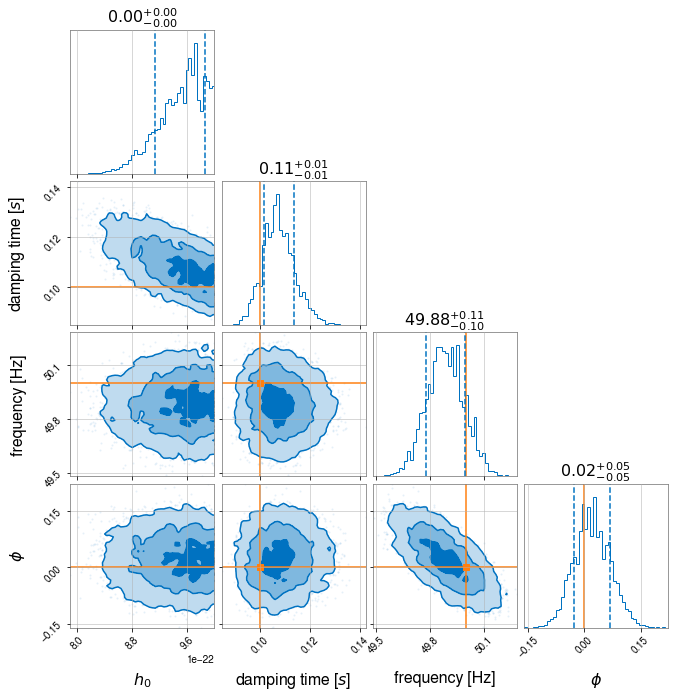

In [8]:
result.plot_corner()